# Math  1376: Programming for Data Science
---

In [1]:
import numpy as np #We will use numpy in this lecture
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from matplotlib.patches import Polygon 
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

from mpl_toolkits.mplot3d import axes3d #This enables 3d plotting

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
%matplotlib inline

In [3]:
import pandas as pd

## Module 06: The beginnings of Machine Learning

In this lecture, we begin exploring how to use Python to perform the basics of machine learning. 
We are primarily going to touch on material covered in the initial chapters out of Sebastian Raschka's book [Python Machine Learning (3rd edition)](https://github.com/rasbt/python-machine-learning-book-3rd-edition). 


Specifically, we will selectively sample and build upon material from the following chapters: 

- Chapter 2: Training Machine Learning Algorithms for Classification
- Chapter 3: A Tour of Machine Learning Classifiers Using Scikit-Learn ***(This notebook's focus)***
- Chapter 4: Building Good Training Datasets – Data Preprocessing
- Chapter 5: Compressing Data via Dimensionality Reduction
- Chapter 6: Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In the spirit of making arbitrary and capricious decisions, I declare that everything beyond these chapters is *advanced* and left for topics in a future course or self-study.

## Learning Objectives
---

* Be able to implement classifiers from the scikit-learn library.
* Explain the difference between training and test data and be able to split a dataset into training and test data subsets.  
* Implement feature-scaling. 
* Explain what a support vector machine is, the margin, and how we avoid overfitting.
* Implement the kernel trick for nonlinear problems.

## Notebook contents <a id='Contents'>


* <a href='#tour'>Part (b)(i): A Tour of Machine Learning Classifiers and Data-Preprocessing Using [Scikit-Learn](https://scikit-learn.org/stable/)</a>
<br><br>
* <a href='#svm'>Part (b)(ii): Support Vector Machines (SVMs)</a>
<br><br>
* <a href='#kernel-trick'>Part (b)(iii): The kernel trick for nonlinear problems</a>    
<br><br>
* <a href='#activity-summary'>Activity: Summary</a>

## <a id='tour'> Part (b)(i): A Tour of Machine Learning Classifiers and Data-Preprocessing Using [Scikit-Learn](https://scikit-learn.org/stable/) </a>

---

### Some useful source material

- https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch03/ch03.ipynb
- https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb
- https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb
- https://scikit-learn.org/stable/ ***<----- !!!! Bookmark this !!!!***
- https://scikit-learn.org/stable/supervised_learning.html#supervised-learning 

<span style='background:rgba(255,255,0, 0.25); color:black'> Run the code cell below and click the "play" button to see the first recorded lecture associated with this notebook.</span>

In [4]:
# 1. Running this cell with embed the short recorded lecture associated with this part of the notebook
# 2. Press on the "play" button to start the video.

from IPython.display import YouTubeVideo

YouTubeVideo('Still-need-to-create', width=800, height=300)

## Jumping right into the fire: comparing classifiers with scikit-learn
---

Below, we parse out the [comparing classifiers example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) from scikit-learn. 

I have included some of my own comments to this example including questions about interesting attributes each of the classification objects possesses. 

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Goals for this example:*** <span>:

1. Develop an overall sense of the variety of classifiers available in scikit-learn. 
<br><br>

2. Observe the performance of these classifiers on datasets with different qualitative characteristics.

    - This will also illustrate the variety of tools available for constructing artificial datasets to test classifiers or for applying new algorithms that we may develop on our own.
<br><br>

3. Understand how some of the available data preprocessing tools work. 

    - This includes both feature scaling and splitting datasets into train/test subsets to assess performance.
    

In [5]:
# First we import a bunch of functions from scikit-learn
#
# Pay attention to which ones end with "Classifier"

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [6]:
# Create a list of names describing the various classifiers being compared - useful for annotating plots
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [7]:
# Create a list of the various classifiers being compared
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [8]:
# Create data sets with different qualitative aspects to compare classifiers

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

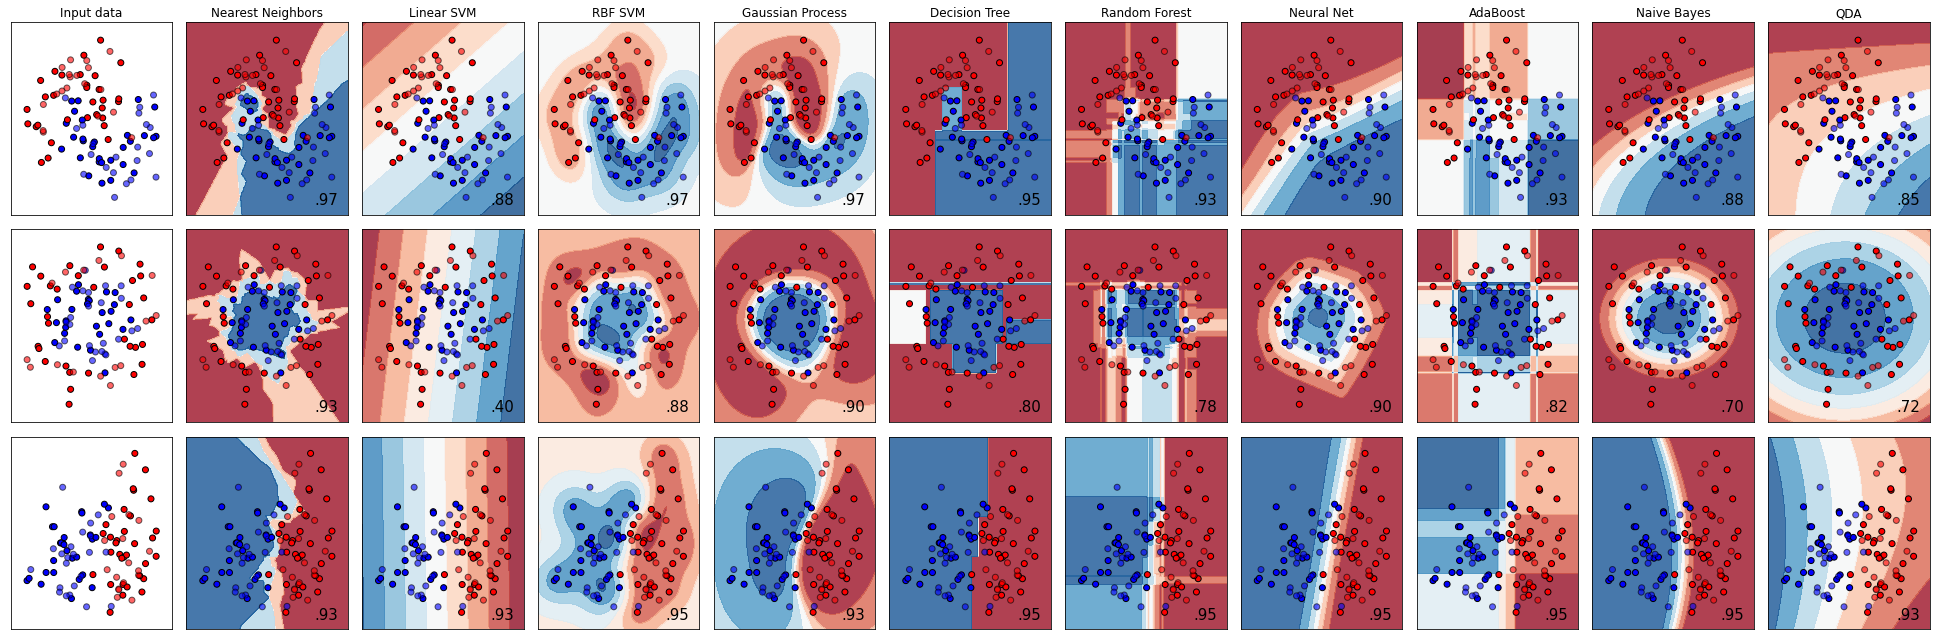

In [9]:
fig = plt.subplots(figsize=(27,9))
h = .02  # step size in the mesh - this makes plots look "nice"

i = 1 # Used to index plotting

# Now iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # First preprocess datasets by splitting into training and test parts
    X, y = ds
    X = StandardScaler().fit_transform(X) #FEATURE SCALING!!! BUT THIS IS IN THE WRONG PLACE!
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42) #WHAT IS THIS???

    # Setup plotting variables
    # I would have opted for x1_* and x2_* (or x0_* and x1_*) variable names
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train) # Learn the weights and bias
        score = clf.score(X_test, y_test) # WHAT IS THIS???

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):  # WHAT IS THIS??? hasattr? Look it up - related to classes
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()

## Well that was...illuminating? Probably not...interesting? Maybe...
---

Okay, what was that exactly? It was just an overview. Scikit-learn has a lot of nice built-in classifiers and general machine learning tools built right into it. It is a bit of a rabbit hole, but we can *navigate* this rabbit hole with what we have learned so far. Along the way, we will learn about some of the best practices in data science. 

As a first step, let's first familiarize ourselves with some of the documentation for the data preprocessing tools used in the code above. 

### Feature scaling
---

We begin with the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) that was imported with this command
`from sklearn.preprocessing import StandardScaler`

In the [source](https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/preprocessing/_data.py#L520) code (see the top-right area of the documentation page), you will see that `StandardScaler` is a class with a few useful attributes. It also inherits some methods from the base class such as [`fit_transform`](https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/base.py#L544) which is a useful wrapper function for any data pre-processing sub-class. In fact, the only pre-processing done was the following

> `X = StandardScaler().fit_transform(X)`

This simply removes the mean from data and then divides by the standard deviation (i.e., performing data normalization), and returns the output, which we use to overwrite the previous `X` data.

Below, we first take the `linearly_separable` dataset, perform standard scaling, and then compare it to the original dataset. We also do this with the "moons" dataset.

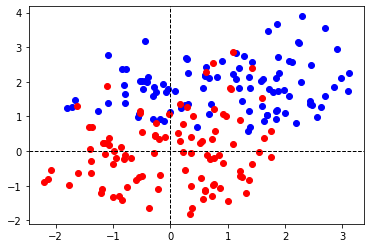

In [10]:
# The linearly separable dataset
data_set_idx = 2
X, _ = datasets[data_set_idx]

X = StandardScaler().fit_transform(X)

plt.figure()
plt.scatter(datasets[data_set_idx][0][:,0], datasets[data_set_idx][0][:,1], c='b')
plt.scatter(X[:,0], X[:, 1], c='r')
plt.axhline(0, linewidth=1, linestyle='--', c='k') #plot typical x-axis
plt.axvline(0, linewidth=1, linestyle='--', c='k') #plot typical y-axis

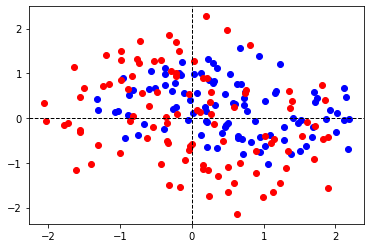

In [11]:
# The moons data set
data_set_idx = 0
X, _ = datasets[data_set_idx]

X = StandardScaler().fit_transform(X)

plt.figure()
plt.scatter(datasets[data_set_idx][0][:,0], datasets[data_set_idx][0][:,1], c='b')
plt.scatter(X[:,0], X[:, 1], c='r')
plt.axhline(0, linewidth=1, linestyle='--', c='k') #plot typical x-axis
plt.axvline(0, linewidth=1, linestyle='--', c='k') #plot typical y-axis

### Why did I say the feature scaling was in the wrong place?
---

Look at my comment in the code:

> `X = StandardScaler().fit_transform(X) #FEATURE SCALING!!! BUT THIS IS IN THE WRONG PLACE!`

***This should be after the training and testing subsets are formed.*** It should also be modified so that

- The scaler is first *learned* (i.e., fitted) to the *training* data that it subsequently transforms. 

- The scaler is then *applied* to the *testing* data (i.e., we transform the testing data using the scaling learned from the training data). 

We discuss this more below.

**Lesson?** Not every example you find, even in official documentation, is following the best practices of machine learning. You need to *think* about what you are running. Almost everything runs on the same "garbage in, garbage out" principle no matter how shiny that garbage may look.

### Creating training and testing subsets: what, how, and why?
---

Following the (incorrect placement of) scaling of the datasets, the datasets were then split into training and testing subsets using the following command:

> `X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)`
        
Later in the code, when we iterate over each classifier, we see that the training and testing subsets are used in different ways. Specifically, we see that

> `clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)`
        
The `clf` is the variable used for the current *classifier* in the loop, which clearly means that all classifiers contain methods named `fit` and `score`. 
Choosing the documentation for any particular classifier (e.g., the [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)), we can read about the `fit` and `score` methods.

From the documentation, it is apparent that `fit` is a method that is called to "build" the classifier from the data passed to it. In other words, this is the method that ***learns*** whatever parameters are required by the particular classifier (such as weights and bias for our previous classifiers). 

Similarly, we see that the `score` method produces a mean score on how well the classifier built on training data correctly predicts the labels in the test data. If you dive into the source code a bit, then you will see that this is simply returning the percentage of correctly predicted labels from the test data (there is an optional keyword argument `sample_weight` that can allow you to penalize some incorrect predictions more than others). 

If we used all of the available data to build the classifier, then we could possibly do a better job of minimizing classification errors on this dataset. So, why do we split the data into training and testing subsets? Ostensibly, we expect that we are going to use these classifiers to predict what class some new data belongs to that we have not yet seen. The process of splitting datasets for which we already know the classifications into training and testing subsets allows us to develop a confidence in how the classifier should perform on data it has not yet seen. In other words, we try to avoid [***overfitting***](https://en.wikipedia.org/wiki/Overfitting) the model so that it explains the training data very well but fails to generalize as reliably to unseen data. We will dive into this a little deeper with regards to a concept known as regularization. 

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Summarizing key takeaways:*** <span>:

1. What are training and testing subsets?

   > Training sets are used to build the classifier (i.e., they are used in the ***learning*** of parameters). Testing subsets are used to assess the classifiers predictive ability.

2. How do we split datasets into training and testing subsets?

   > The [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function has various keyword arguments that allow you to specify how you want to split the dataset into training and testing subsets. 
 
  ***Note if you are using or encounter code based on older versions of `sklearn`:*** This function used to be in the submodule `cross_validation` in older versions of `sklearn`, but that submodule has been [deprecated](https://en.wikipedia.org/wiki/Deprecation#Software_deprecation) with certain functionality like the `train_test_split` method being absorbed in the submodule `model_selection`.
<br><br>  
3. Why do we split datasets?

   > To avoid overfitting the model so that it fails to perform well on unseen data.
   
Since *unseen* data will have to first be *scaled* before it can be classified, it should now be rather evident why we should *wait* to transform data until after the splitting into training and testing data.
You can read more about why we want to do this here: https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split. 
I particularly like the part about ***data leakage***. 
It sounds just like a nasty side effect of a drug, and you should definitely stop what you are doing and consult your teacher at the first sign of data leakage. 

<span style='background:rgba(0,255,255, 0.5); color:black'>**Suggested activity**</span>

---

- Copy/paste the code cell that loops through the classifiers and "fix" the way that the feature scaling is done as discussed above.
<br><br>

- Experiment with different `test_size` and `random_state` values in the construction of the training and testing subsets. 
<br><br>

- Make all of this fancier using widgets that allow you to specify different values of `test_size` and `random_state` inputs.
<br><br>

- Comment on your findings in a Markdown cell

### How do I know my train and test split was the best one? (Hint: Cross-validation)
---

Now *that* is a good question. 

You can *never* know that!

Maybe the way you split the dataset ended up with training data that was really bad for learning the parameters in a model. Oh well, huh? I guess you just decide to not use that model then because of a poor choice of training data split from the original dataset. 

WRONG!

[Cross-validation (CV)](https://scikit-learn.org/stable/modules/cross_validation.html) offers a solution. 
Of course, there are multiple types of CV methods.
The basic idea of most CV methods is to split your dataset into many smaller chunks and then loop through the training/testing phases on these chunks of data. 

CV methods are useful (but can be expensive) for choosing the "optimal" model, but they do not actually produce the final model. 
What we typically do is then train the chosen model on *all* of the available data (e.g., read [this](https://machinelearningmastery.com/train-final-machine-learning-model/) for a discussion on training a final model). 

This is probably frustrating to read because we just discussed above how we want to avoid overfitting the model, which is why we do not train it on all of the data. 

Are we going in circles?

Actually, we are in a great place to now discuss regularization methods that help avoid overfitting. Of course, regularization introduces a new hyperparameter (remember learning rates and epochs?). Fortunately, CV methods can also be used to determine "optimal" hyperparameters.  

For the sake of clarity and succinctness, we limit the presentation of these ideas to support vector machines (SVM) for the remainder of this lecture. 

## Part (b)(ii): Support Vector Machines (SVMs) <a id='svm'>
---
    
<span style='background:rgba(255,255,0, 0.25); color:black'> Run the code cell below and click the "play" button to see the second recorded lecture associated with this notebook.</span>

In [12]:
# 1. Running this cell with embed the short recorded lecture associated with this part of the notebook
# 2. Press on the "play" button to start the video.

from IPython.display import YouTubeVideo

YouTubeVideo('Still-need-to-create', width=800, height=300)

A [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) is an extension of the perceptron.
Recall that the perceptron really only works on linearly separable data where it seeks to learn the parameters of the net input function $\mathbf{w}\cdot\mathbf{x}+b$ such that the hyperplane defined by $\mathbf{w}\cdot\mathbf{x}+b=0$ ***separates*** the classifications of data.
However, this separation is not in general unique as we illustrate below.

<img src="which_hyperplane_SVM.png" width=50%>

A SVM formulates attempts to solve this problem by re-formulating it as an optimization problem on the ***margin***. What is the margin? We illustrate the basic concept of margin below.

<img src="maximizing_margin_SVM.png" width=50%>

Basically, we are trying to maximally separate the distinct classes in the data so that the classifier does a good job of avoiding misclassification on unseen data. 
The optimization problem is then stated as:
> Minimize $\sqrt{\sum_{j=1}^m w_j^2}$ subject to the constraints that $y^{(i)}=\mathbf{w}\cdot\mathbf{x}^{(i)}+b$ for $1\leq i\leq N$.

Since minimizing $\sum_{j=1}^m w_j^2$ will minimize $\sqrt{\sum_{j=1}^m w_j^2}$ (the square root is a monotonic increasing function), we instead formulate the optimization problem as:
> Minimize $\frac{1}{2}\sum_{j=1}^m w_j^2$ subject to the constraints that $y^{(i)}=\mathbf{w}\cdot\mathbf{x}^{(i)}+b$ for $1\leq i\leq N$.

Here, we multiply by $\frac{1}{2}$ for convenience just as with the cost function seen in the previous lecture. Basically, we now have a (constrained) *quadratic optimization* problem. There are codes to solve these (which is great because we certainly don't want to do that ourselves). 

While this will in general do a better job than the perceptron in avoiding "overfitting" the data (which we may define here as creating the hyperplane $\mathbf{w}\cdot\mathbf{x}+b=0$ that is *too close* to one of the classes of data), it still suffers from the same basic issue of requiring the data to be linearly separable. In practice, this is going to eliminate a lot of data sets that are *almost* linearly separable. This seems rather unfortunate considering the ADALINE was also based on a (unconstrained) quadratic optimization problem that could be applied to any data set. 

Well, in practice we introduce a *slack variable* that *softens* the margin (i.e., it weakens the constraints that each datum be properly classified). This is done as follows:
> For $1\leq i\leq N$, let $\xi^{(i)}=\max\{0, 1-y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}-b)\}$, which is the smallest non-negative number satisfying $y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}-b)\geq 1-\xi^{(i)}$. Subject to these constraints, minimize the cost function $\left(\frac{1}{2}\sum_{j=1}^m w_j^2\right) + C\sum_i^N \xi^{(i)}$ where $C>0$ is a control how much we penalize a misclassification error. 

The variable $C>0$ is a new *hyperparameter* that is effectively a *regularization* used to control overfitting the data. 

Let's examine the impact of this hyperparameter in the code below.

In [13]:
def visualize_SVM_variable_C(x, y,  C):
    clf = SVC(kernel="linear", C=C)
    
    x = StandardScaler().fit_transform(x)
    
    clf.fit(x, y) # Learn the weights and bias
    
    x1_plot = np.linspace(np.min(x[:,0])-0.1*(np.max(x[:,0])-np.min(x[:,0])), 
                          np.max(x[:,0])+0.1*(np.max(x[:,0])-np.min(x[:,0])),
                          51)
    x2_plot = np.linspace(np.min(x[:,1])-0.1*(np.max(x[:,1])-np.min(x[:,1])), 
                          np.max(x[:,1])+0.1*(np.max(x[:,1])-np.min(x[:,1])), 
                          51)
    x1_plot, x2_plot = np.meshgrid(x1_plot, x2_plot)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.decision_function(np.c_[x1_plot.ravel(), x2_plot.ravel()])
    
    # Put the result into a color plot
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    Z = Z.reshape(x1_plot.shape)
    ax.contourf(x1_plot, x2_plot, Z, cmap=cm, alpha=.8, levels=50)

    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright,
               edgecolors='k')

    ax.set_xlim(x1_plot.min(), x1_plot.max())
    ax.set_ylim(x2_plot.min(), x2_plot.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    score = clf.score(x, y)
    title_str = 'SVM score = {:.2f}%'.format(score*100)
    ax.set_title(title_str, fontsize=18)

In [14]:
# Create training data
num_training = 100
bbox_1 = np.array([[0.5, 0], [1.5, 4]]) #first row is lower-left point and second row is upper-right point of class -1
bbox_2 = np.array([[2, 2], [4, 4]]) # " " of class 1
# Will assume equal probability of training data being in either box
pseudo_data = np.random.uniform(low=0, high=1, size=num_training)
x_data = np.zeros((num_training,2))
y_data = -np.ones(num_training)
for i in range(num_training):
    if pseudo_data[i]<0.5:
        x_data[i,0] = np.random.uniform(low=bbox_1[0,0], high=bbox_1[1,0])
        x_data[i,1] = np.random.uniform(low=bbox_1[0,1], high=bbox_1[1,1])
    else:
        x_data[i,0] = np.random.uniform(low=bbox_2[0,0], high=bbox_2[1,0])
        x_data[i,1] = np.random.uniform(low=bbox_2[0,1], high=bbox_2[1,1])
        y_data[i] = 1

In [15]:
%reset -f out

interact(visualize_SVM_variable_C, 
         x = widgets.fixed(x_data),
         y = widgets.fixed(y_data),
         C = widgets.FloatText(value=0.025, step=0.01))

Flushing output cache (4 entries)


interactive(children=(FloatText(value=0.025, description='C', step=0.01), Output()), _dom_classes=('widget-int…

<function __main__.visualize_SVM_variable_C(x, y, C)>

Let's re-examine the basketball data from the previous lecture.

In [16]:
Off_Eff = []
Def_Eff = []

y = []

iter = 0
for year in range(2009, 2020):
    url = 'http://www.espn.com/nba/hollinger/teamstats/_/year/' + str(year)
    df_regular_season = pd.read_html(url)[0]
    Off_Eff.append(df_regular_season.loc[2:, 10].values)
    Def_Eff.append(df_regular_season.loc[2:, 11].values)
    
    N = len(df_regular_season.loc[2:, 1].values)
    
    y.append(-np.ones(N))
    url += '/seasontype/3'
    df_playoffs = pd.read_html(url)[0]
    
    playoff_teams = df_playoffs.loc[2:,1].values
    all_teams = df_regular_season.loc[2:,1].values
    for i in range(16):
        for j in range(N):
            if playoff_teams[i] == all_teams[j]:
                y[iter][j] = 1
    iter += 1

In [17]:
Off_Eff_All = np.concatenate(Off_Eff).astype('float')
Def_Eff_All = np.concatenate(Def_Eff).astype('float')

bball_features = np.vstack((Off_Eff_All.flatten(), Def_Eff_All.flatten())).T

playoffs_All = np.concatenate(y)

In [18]:
%reset -f out

interact(visualize_SVM_variable_C, 
         x = widgets.fixed(bball_features),
         y = widgets.fixed(playoffs_All),
         C = widgets.FloatText(value=0.025, step=0.01))

Flushing output cache (1 entries)


interactive(children=(FloatText(value=0.025, description='C', step=0.01), Output()), _dom_classes=('widget-int…

<function __main__.visualize_SVM_variable_C(x, y, C)>

## Part(b)(iii): The kernel trick for nonlinear problems <a id='kernel-trick'>
---

<span style='background:rgba(255,255,0, 0.25); color:black'> Run the code cell below and click the "play" button to see the third recorded lecture associated with this notebook.</span>

In [19]:
# 1. Running this cell with embed the short recorded lecture associated with this part of the notebook
# 2. Press on the "play" button to start the video.

from IPython.display import YouTubeVideo

YouTubeVideo('Still-need-to-create', width=800, height=300)

In [20]:
# We use this to create visualizations in this part of the notebook
def visualize_SVM_variable_kernel(x, y, ker='linear', C=1e-2):
    clf = SVC(kernel=ker, C=C)
    
    x = StandardScaler().fit_transform(x)
    
    clf.fit(x, y) # Learn the weights and bias
    
    x1_plot = np.linspace(np.min(x[:,0])-0.1*(np.max(x[:,0])-np.min(x[:,0])), 
                          np.max(x[:,0])+0.1*(np.max(x[:,0])-np.min(x[:,0])),
                          51)
    x2_plot = np.linspace(np.min(x[:,1])-0.1*(np.max(x[:,1])-np.min(x[:,1])), 
                          np.max(x[:,1])+0.1*(np.max(x[:,1])-np.min(x[:,1])), 
                          51)
    x1_plot, x2_plot = np.meshgrid(x1_plot, x2_plot)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.decision_function(np.c_[x1_plot.ravel(), x2_plot.ravel()])
    
    # Put the result into a color plot
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    Z = Z.reshape(x1_plot.shape)
    ax.contourf(x1_plot, x2_plot, Z, cmap=cm, alpha=.8, levels=50)

    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright,
               edgecolors='k')

    ax.set_xlim(x1_plot.min(), x1_plot.max())
    ax.set_ylim(x2_plot.min(), x2_plot.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    score = clf.score(x, y)
    title_str = 'SVM score = {:.2f}%'.format(score*100)
    ax.set_title(title_str, fontsize=18)

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Feature space mappings:*** <span>

- Suppose there exists a "feature mapping" function $\phi(\cdot)$ that maps the features $\mathbf{x}$ into a new *higher-dimensional* feature space, with feature vectors now denoted by $\mathbf{z}$, so that the associated classifications defined by $\mathbf{y}$ are "more clearly separated." In other words, we transform the data $\{(\mathbf{x}^{(i)},y^{(i)})\}_{i=1}^N$ into the form $\{(\mathbf{z}^{(i)},y^{(i)})\}_{i=1}^N$. If $m$ denotes the dimension of the original feature space, then let $m+f$ denote the dimension of the new feature space where $f$ denotes the additional "fake" features defined by the mapping
<br><br>
- The classifier is then constructed on the data set $\{(\mathbf{z}^{(i)},y^{(i)})\}_{i=1}^N$. 
<br><br>
- What are the disadvantages of feature mapping?
<br><br>Storing higher-dimensional feature vectors $\mathbf{z}$ requires more memory. Also, the quadratic programming task required to train an SVM involves inner products of the feature space, which is now computationally more expensive. 
<br><br> 

We show an example of a feature mapping below (without dealing with the SVM part).

In [21]:
# Create data that is not even "almost" linearly separable
X_circle_data, Y_circle_data = make_circles(noise=0.1, factor=0.2, random_state=1)

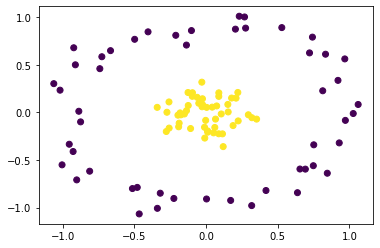

In [22]:
# Visualize the separable data. While there is no good "dividing line" 
# we can certainly see that there is a curve (in this case a circle) that
# separates the classes.
plt.figure()
plt.scatter(X_circle_data[:,0], X_circle_data[:,1], c=Y_circle_data)

In [23]:
# Define a feature mapping that utilizes the knowledge
# that there is a "hidden" circular feature in the data
def phi_4_circle_data(X):
    n = len(X)
    Z = np.zeros((n,3))
    Z[:,0:2] = X
    Z[:,2] = X[:,0]**2 + X[:,1]**2 # This is the square of the radii of circles passing through the feature data
    return Z

In [24]:
# Map the 2-D features into a new 3-D feature space
Z = phi_4_circle_data(X_circle_data)

In [25]:
from mpl_toolkits.mplot3d import axes3d

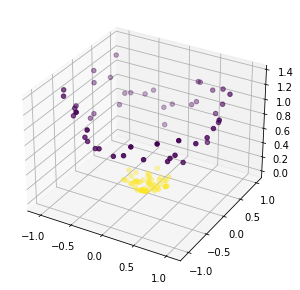

In [26]:
# Visualize the separability in this higher-dimensional feature space
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(Z[:,0], Z[:,1], Z[:,2], c=Y_circle_data)

<span style='background:rgba(255,0,255, 0.25); color:black'> ***The kernel trick:*** <span>

- The "kernel trick" is that instead of computing $\mathbf{z}^{(i)}=\phi(\mathbf{x}^{(i)})$ for each datum $\mathbf{x}^{(i)}$, we define a kernel function, $k(\cdot,\cdot)$ such that $k(\mathbf{x}^{(i)},\mathbf{x}^{(j)}) = \phi(\mathbf{x}^{(i)})^\top\phi(\mathbf{x}^{(j)})$.
<br><br>
    In other words, we work directly on the original feature space when training the classifier so that we do not have to explicitly create and store the higher-dimensional features $\mathbf{z}^{(i)}$ for each $1\leq i\leq N$ in memory. We just simply compute the inner products required in the training step directly.
<br><br>


We show this below for the circle data above.

In [27]:
# Don't worry how I came up with this
def circle_kernel(x_i, x_j):
    k = np.dot(x_i,x_j.T) + np.tensordot(np.linalg.norm(x_i,ord=2,axis=1),np.linalg.norm(x_j,ord=2,axis=1),axes=0)**2
    return k

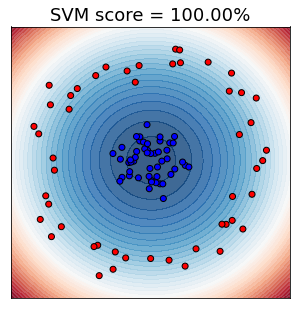

In [28]:
visualize_SVM_variable_kernel(X_circle_data, Y_circle_data, ker=circle_kernel)

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Interpreting and using different kernels:*** <span>

- A kernel may also be referred to as a *similarity function* that describes how similar two samples are to each other. In fact, this is related to the idea of radial basis functions (RBFs) from a module 03 assignment. 
<br><br>
- The "default" choice for a kernel is often the Gaussian RBF, which is often referred to simply as "the RBF kernel" and usually passed to the classifer as the string `'rbf'`. 
<br><br>
    - The Gaussian RBF introduces another hyperparameter, which we will not worry about here.
    <br><br>
- Other common kernel options are `'linear'`, `'poly'`, and `'sigmoid'` (read more about these in the documentation of SVM here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
<br><br>
    - As with the Gaussian RBF, the `'poly'` and `'sigmoid'` introduce another hyperparameter. We again do not worry about that here.

Generally, people first try out these common "built-in" kernels before trying to do anything that is user-defined like we did above. 

Let's try different kernels on the circle data. 

In [29]:
%reset -f out

interact_manual(visualize_SVM_variable_kernel, 
         x = widgets.fixed(X_circle_data),
         y = widgets.fixed(Y_circle_data),
         ker = widgets.Text('rbf'),
         C = widgets.FloatText(value=0.025, step=0.01))

Flushing output cache (4 entries)


interactive(children=(Text(value='rbf', description='ker'), FloatText(value=0.025, description='C', step=0.01)…

<function __main__.visualize_SVM_variable_kernel(x, y, ker='linear', C=0.01)>

Now try this out on the basketball data

In [30]:
%reset -f out

interact_manual(visualize_SVM_variable_kernel, 
         x = widgets.fixed(bball_features),
         y = widgets.fixed(playoffs_All),
         ker = widgets.Text('rbf'),
         C = widgets.FloatText(value=0.025, step=0.01))

Flushing output cache (1 entries)


interactive(children=(Text(value='rbf', description='ker'), FloatText(value=0.025, description='C', step=0.01)…

<function __main__.visualize_SVM_variable_kernel(x, y, ker='linear', C=0.01)>

<hr style="border:5px solid cyan"> </hr>

## <span style='background:rgba(0,255,255, 0.5); color:black'>Activity: Summary</span> <a id='activity-summary'/></a>

Summarize some of the key takeaways/points from this notebook in a list below and prepare a few code examples related to these takeaways/points in the code cells below. You need to have at least one example for each of your summary points and you need at least three summary points.

In this notebook, we have seen the following:

- [Your summary point 1 goes here]


- [Your summary point 2 goes here]


- [Your summary point 3 goes here]

<hr style="border:5px solid cyan"> </hr>

### <a href='#Contents'>Click here to return to Notebook Contents</a>